# Import Libs

In [0]:
# dataframe, plotting and wrangling
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pickle
from scipy import sparse
from collections import Counter
import itertools
from random import sample
import scipy
from sklearn.cluster import DBSCAN

#import NLP liberaries:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
import re


#if you runing on Colab install these first:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
!pip install gensim
import gensim
nltk.download('words')

# Functions

In [0]:
# this function removes low freq and stopwords for visulization and classification.
def text_cleaner(text, min_freq):
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    words = set(nltk.corpus.words.words())
    txt = []
    tokens_after = []
    tokens = []
    for i in text:
        tokenized = word_tokenize(i)
        tokens.extend(tokenized)
    len_before = len(tokens)
    dic = Counter(tokens)
    for i in range(len(text)):
        temp = text[i]
        temp = temp.strip().lower()
        cleaned = re.sub('\W+', ' ', temp)
        tokenized = word_tokenize(cleaned)
        filtered = [word for word in tokenized if word not in stop_words]
        filtered_En = [word for word in filtered if word in words]
        lemmatized = [lemmatizer.lemmatize(token) for token in filtered_En]
        freq = [word for word in lemmatized if dic[word]>min_freq]
        tokens_after.extend(freq)
        string = TreebankWordDetokenizer().detokenize(freq)
        txt.append(string)
    len_after = len(tokens_after)
    dic_after = Counter(tokens_after)
    return(txt, dic, dic_after, len_after, len_before)

# this function does not remove low freq nor stopwords for the sake of training of W2V
def text_cleaner_w2v(text):
  stop_words = stopwords.words('english')
  lemmatizer = WordNetLemmatizer()
  words = set(nltk.corpus.words.words())
  txt = []
  tokens_after = []
  tokens = []
  for i in text:
      tokenized = word_tokenize(i)
      tokens.extend(tokenized)
  len_before = len(tokens)
  dic = Counter(tokens)
  for i in range(len(text)):
      temp = text[i]
      temp = temp.strip().lower()
      cleaned = re.sub('\W+', ' ', temp)
      tokenized = word_tokenize(cleaned)
      filtered_En = [word for word in tokenized if word in words]
      lemmatized = [lemmatizer.lemmatize(token) for token in filtered_En]
      tokens_after.extend(lemmatized)
      string = TreebankWordDetokenizer().detokenize(lemmatized)
      txt.append(string)
  len_after = len(tokens_after)
  dic_after = Counter(tokens_after)
  return(txt, dic, dic_after, len_after, len_before)

#this function gets a list of comments and returns the averaged vector based on the embedding_matrix.
#min_character_in_comment: comments shorter than this are not counted, 0 keeps all comments.
def vector_averager(txt,embeddings_index, min_character_in_comment):
  comment_vectors = []
  for i in txt:
    if len(i)>min_character_in_comment:
      tokenized = word_tokenize(i)
      comment_vector = [0]*100
      for j in tokenized:
        if j in embeddings_index:
          comment_vector.append(embeddings_index[j])
      avg = (np.average(np.array(comment_vector), axis = 0)).tolist()
    else:
      avg = [0]*100
    comment_vectors.append((avg))
    return comment_vectors

# Import Data

### From Google Drive

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'the shareable link to your file on googl.drive' 
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  
df = pd.read_csv('train.csv')
df.head()

1f7lwaGJfI8n14pZexrCM6momI2hNzD0E


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### From Disk






In [0]:
# if you upload the file into google colab from disk (for small size files otherwise takes forever!)
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['train.csv']), encoding = "ISO-8859-1")
df.head()

# PreProcessing

In [0]:
# cleaning includes removing stopwords and low frequently words.
text = df['comment_text'].tolist()
txt, dic_before, dic_after,len_after, len_before  = text_cleaner(text, 10)
print("Number of all words: ", len_before)
print('number of unique word before cleaning:', len(dic_before))
print("Number of all words after cleaning: ", len_after)
print('number of unique word after cleaning:', len(dic_after))

Number of all words:  12817094
number of unique word before cleaning: 304749
Number of all words after cleaning:  3812175
number of unique word after cleaning: 10258


In [0]:
#prepared for w2v; stopwords and low frequently words are not removed
text = df['comment_text'].tolist()
txt_w2v, dic_before, dic_after,len_after, len_before  = text_cleaner_w2v(text)
print("Number of all words: ", len_before)
print('number of unique word before cleaning:', len(dic_before))
print("Number of all words after cleaning: ", len_after)
print('number of unique word after cleaning:', len(dic_after))

Number of all words:  12817094
number of unique word before cleaning: 304749
Number of all words after cleaning:  9180915
number of unique word after cleaning: 32377


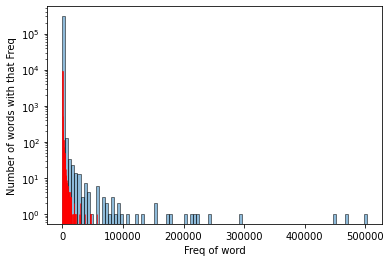

In [0]:
values_before = dic_before.values()
values_before = sorted(values_before)
plt.hist(values_before, bins = 100, edgecolor = 'black',alpha = 0.5, histtype='bar', label = 'before Cleaning')
values = dic_after.values()
values = sorted(values)
plt.hist(values, bins = 100, edgecolor = 'red',alpha = 0.7, histtype='bar', color = 'red', label = 'After Cleaning');
plt.yscale('log')
plt.xlabel('Freq of word')
plt.ylabel('Number of words with that Freq');

# Train Embedding matrix using W2V

In [0]:
txt_w2v = pickle.load(open('txt_wiki_stop_left.pkl','rb'))
tokens = []
for i in txt_w2v:
    tokenized = word_tokenize(i)
    tokens.append(tokenized)
model = gensim.models.Word2Vec(tokens,min_count = 10, size = 100, window = 10, workers=10, iter= 20, sample=0.001)
#save the model
model.wv.save_word2vec_format('wiki_w2v.txt', binary = False) #binary should be false so readable as text

In [0]:
model.wv.most_similar(positive = 'man')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('boy', 0.6580595374107361),
 ('woman', 0.6335050463676453),
 ('freaky', 0.6316742897033691),
 ('pervert', 0.6075737476348877),
 ('chameleon', 0.6052546501159668),
 ('guy', 0.5986287593841553),
 ('hero', 0.5985522270202637),
 ('girl', 0.5980728268623352),
 ('cried', 0.5704896450042725),
 ('evil', 0.5687756538391113)]

# Upload pretrained embedding matrix from glove

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip
# for more details on how use GloVe on Colab please see: 
# https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory

In [0]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

### Make Embedding Matrix

In [0]:
#W2V dict made on imdb
import os
embeddings_index = dict()
f = open('wiki_w2v.txt',  encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
vocab_size = len(embeddings_index)

Loaded 12971 word vectors.


### Averaging

In [0]:
comment_vectors = vector_averager(txt,embeddings_index, min_character_in_comment = 10)

# TSNE

In [0]:
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250)
tsne_results = tsne.fit_transform(comment_vectors)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

## Give color to each label

In [0]:
colors = []
for i in (range(len(df))):
  if df['comment_text'][i] ==1:
    colors.append('red')
  elif df['toxic'][i]==1:
    colors.append('blue')
  elif df['threat'][i]==1:
    colors.append('yellow')
  elif df['obscene'][i]==1:
    colors.append('pink')
  elif df['insult'][i]==1:
    colors.append('orange')
  elif df['identity_hate'][i]==1:
    colors.append('brown')
  else:
    colors.append('yellow')


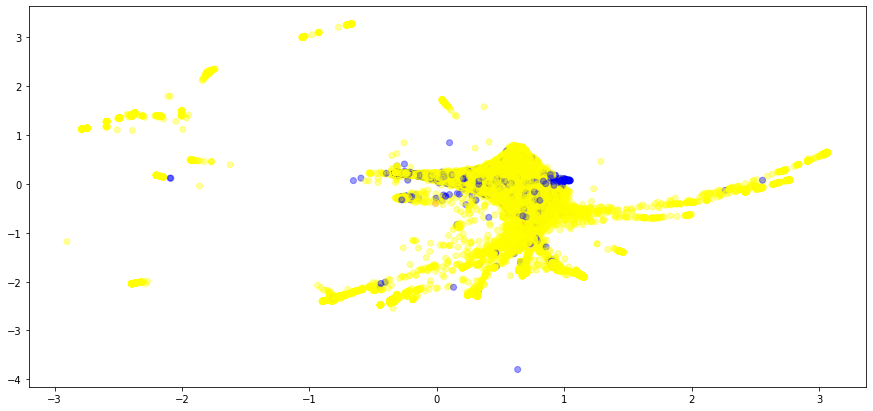

In [0]:
pdf = pd.DataFrame(data = tsne_results
             , columns = ['one', 'two'])
a = pdf['one'].tolist()
b = pdf['two'].tolist()
plt.figure(figsize=(15,7))
plt.scatter(a,b, alpha=0.3899, c = colors)
#plt.axis([-1, 1.5, -2, 1])

# PCA

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.array(comment_vectors))
pdf = pd.DataFrame(data = principalComponents
             , columns = ['one', 'two'])

# PCA: Labeling the 2D Distribution

### PCA: pretrained emvedding matrix (100D) for GloVe

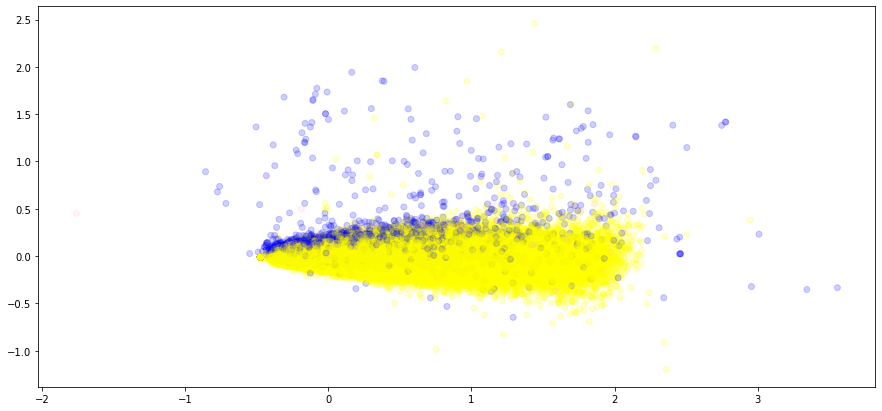

In [0]:
#same color labels as TSNE
a = pdf['one'].tolist()
b = pdf['two'].tolist()
plt.figure(figsize=(15,7))
plt.scatter(a,b, alpha=0.1899, c = colors)

### PCA: stopwords and low freq words removed in training w2v and PCA

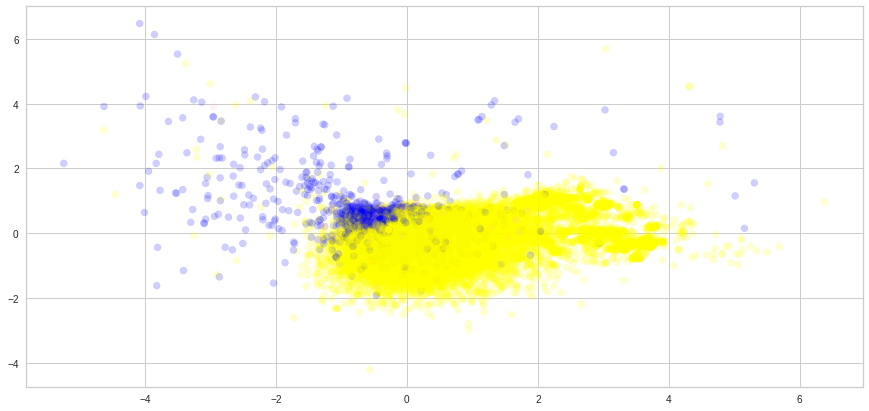

In [0]:
a = pdf['one'].tolist()
b = pdf['two'].tolist()
plt.figure(figsize=(15,7))
plt.scatter(a,b, alpha=0.1899, c = colors)

### PCA: stopwords and low freq words not-removed in training w2v and  but removed in PCA

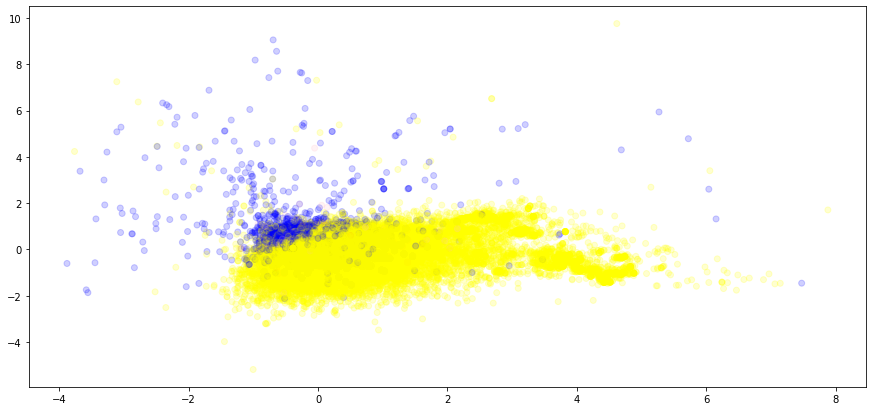

In [0]:
#w2v stopwords remained in training but not in averaging:
a = pdf['one'].tolist()
b = pdf['two'].tolist()
plt.figure(figsize=(15,7))
plt.scatter(a,b, alpha=0.1899, c = colors)
#plt.axis([-1, 1, -1, 1])

### PCA: stopwords and low freq words NOT removed in training w2v and PCA

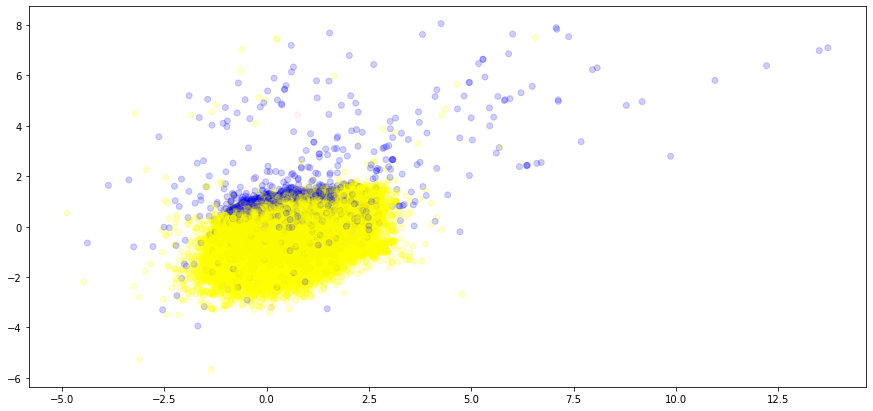

In [0]:
#w2v stopwords remained in training and averaging:
a = pdf['one'].tolist()
b = pdf['two'].tolist()
plt.figure(figsize=(15,7))
plt.scatter(a,b, alpha=0.1899, c = colors)
#plt.axis([-1, 1, -1, 1])

# K_mean Clustering

1
2
3
4
5
6
7
8
9
10
11
12
13
14


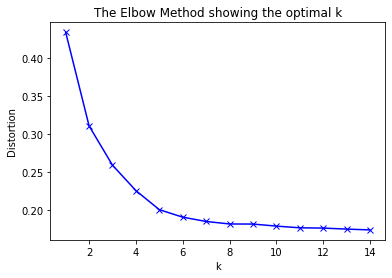

In [0]:
#using glove pretrained on cleaned text

distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(comment_vectors)
    kmeanModel.fit(comment_vectors)
    distortions.append(sum(np.min(cdist(comment_vectors, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / np.shape(comment_vectors)[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()  

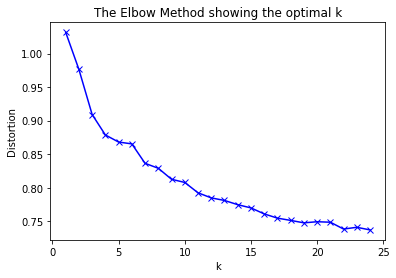

In [0]:
#using embedding matrix trained on commen text

distortions = []
K = range(1,25)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(comment_vectors)
    kmeanModel.fit(comment_vectors)
    distortions.append(sum(np.min(cdist(comment_vectors, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / np.shape(comment_vectors)[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()  

### K_means: 5 clusters on GloVe pre_trained

In [0]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(comment_vectors)
y_kmeans = kmeans.predict(comment_vectors)

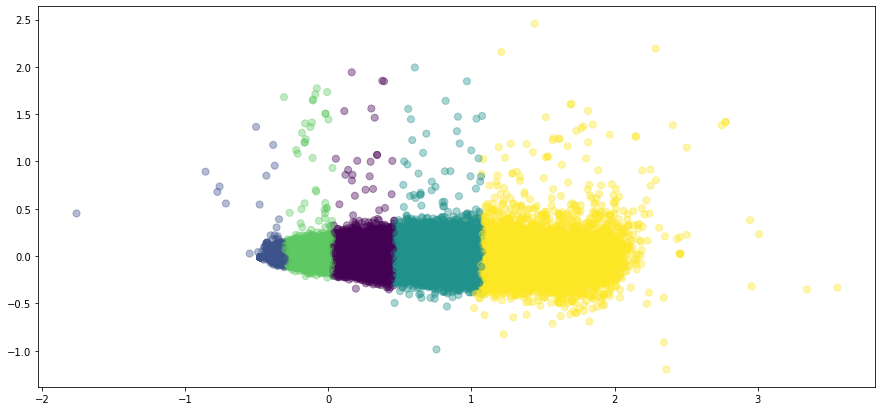

In [0]:
plt.figure(figsize=(15,7))
plt.scatter(a, b, c=y_kmeans, s=50, cmap='viridis', alpha=0.3899);

### K_means: 9 clusters on embedding matrix trained on comments (low freq/stop words removed)

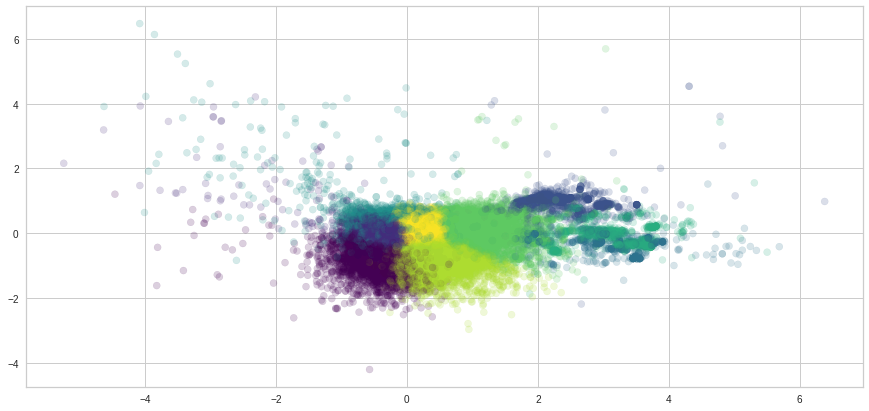

In [0]:
plt.figure(figsize=(15,7))
plt.scatter(a, b, c=y_kmeans, s=50, cmap='viridis', alpha=0.1899);

### K_means: 9 clusters on embedding matrix trained on comments (low freq/stop words were Not remove)

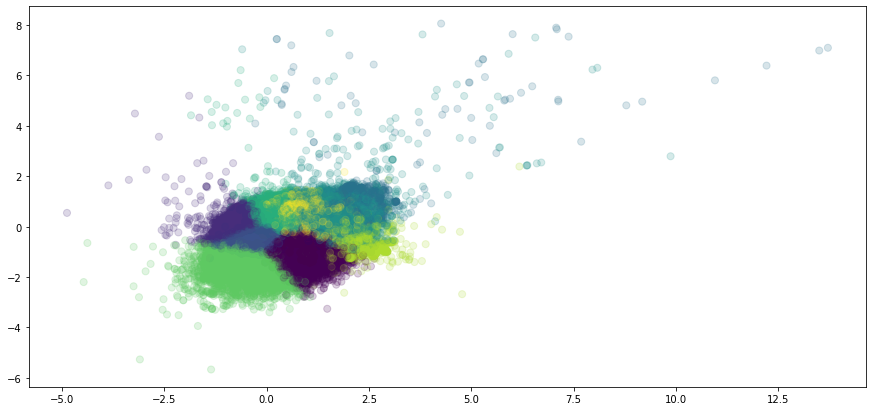

In [0]:
plt.figure(figsize=(15,7))
plt.scatter(a, b, c=y_kmeans, s=50, cmap='viridis', alpha=0.1899);

# DBScan

In [0]:
dbscan = DBSCAN( min_samples = 200, n_jobs = -1)
clusters = dbscan.fit_predict(comment_vectors)# plot the cluster assignments

Text(0, 0.5, 'Feature 1')

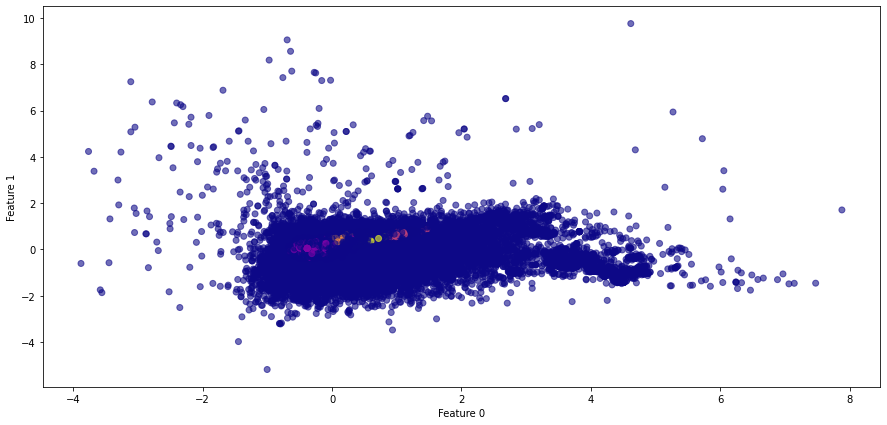

In [0]:
a = pdf['one'].tolist()
b = pdf['two'].tolist()
plt.figure(figsize=(15,7))
plt.scatter(a, b, c=clusters, alpha=0.5899, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")